# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('azdias.csv', sep=';', index_col = 'Unnamed: 0')
customers = pd.read_csv('customers.csv', sep=';', index_col = 'Unnamed: 0')

/var/folders/jg/ltscjj4d0cn9rp9tg94kl1kr0000gn/T/ipykernel_12893/1918823406.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('azdias.csv', sep=';', index_col = 'Unnamed: 0')
/var/folders/jg/ltscjj4d0cn9rp9tg94kl1kr0000gn/T/ipykernel_12893/1918823406.py:3: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('customers.csv', sep=';', index_col = 'Unnamed: 0')


In [4]:
azdias_bkp = azdias
customers_bkp = customers

In [5]:
features_info = pd.read_csv('features_info.csv', sep=',')

In [6]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
features_info

,Information level,Attribute,Description,Additional notes
0,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,Community,EINWOHNER,inhabitants,NaN
310,Community,GKZ,standardized community-code,NaN
311,Community,ORTSGR_KLS9,classified number of inhabitants,NaN


In [9]:
print('azdias shape:', azdias.shape)
print('customers shape:', customers.shape)

print("Num. of columns in azdias: ", len(list(azdias.columns)))
print("Num. of columns in customers: ", len(list(customers.columns)))

x = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data: ", x)

azdias shape: (891221, 366)
customers shape: (191652, 369)
Num. of columns in azdias:  366
Num. of columns in customers:  369
Extra columns in Customers Data:  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


The features_info table is a is a support table in which we have information about the level of information, description and additional notes. This information is *essential* to bring understanding about the base and guide decisions that will have to be taken in these projects.

In [10]:
features_info.index = features_info['Attribute']
features_info = features_info.drop(columns=['Attribute'])
features_info.head()

,Information level,Description,Additional notes
Attribute,,,
AGER_TYP,Person,best-ager typology,in cooperation with Kantar TNS; the informatio...
ALTERSKATEGORIE_GROB,Person,age through prename analysis,modelled on millions of first name-age-referen...
ANREDE_KZ,Person,gender,NaN
CJT_GESAMTTYP,Person,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
FINANZ_MINIMALIST,Person,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [11]:
y = [col for col in azdias.columns if col not in features_info.index]
print("Columns without context ", y)

Columns without context  ['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLIN

As we don't have information about these features we will exclude them from further analysis, as it would be very difficult to extract insights since we don't know what they mean.

In [12]:
azdias = azdias.drop(columns = y)

## Missing Values

Understanding the distribution of null values and handling them is extremely important in this project. We will start by analyzing the null values of azdia in order to find patterns and understand what can be excluded from the base and what should undergo other types of interventions.

### By Collumns

In [13]:
azdias_mv = azdias.isnull().mean()

In [14]:
print('Collumns with no missing value:', azdias_mv[azdias_mv == 0].count())

Collumns with no missing value: 47


In [15]:
#Top 10 collumns with missing values
azdias_mv.sort_values(ascending=False).head(10)

D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_KONSUMTYP                  0.288495
KBA05_ALTER3                   0.149597
KBA05_ANTG3                    0.149597
KBA05_ANTG2                    0.149597
KBA05_ANTG1                    0.149597
KBA05_ANHANG                   0.149597
KBA05_ALTER4                   0.149597
dtype: float64

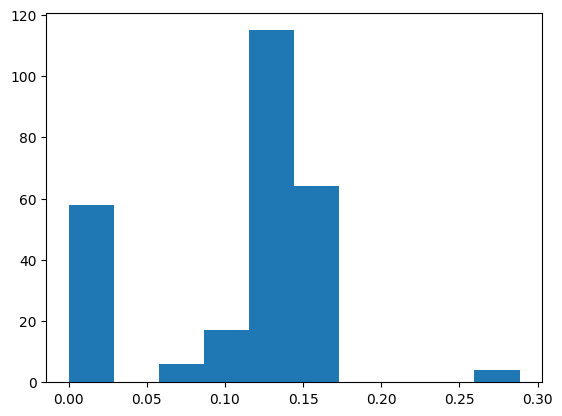

In [16]:
plt.hist(azdias_mv, bins=10);

As most of the features have up to 20% null data, we will consider 0.2 as our threshold to exclude columns that have more than 20% null data.

In [17]:
azdias_col_threshold = 0.2
droping = azdias_mv[azdias_mv > azdias_col_threshold]
droping.index

Index(['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12'],
      dtype='object')

In [18]:
print('Columns to drop:', droping.count())

Columns to drop: 4


Before deleting the columns, we will create a backup of the bases, in case it is necessary to make some kind of comparison with the original base.

In [19]:
#Droping the columns with more than 20% of missing values
azdias = azdias.drop(columns = droping.index)

In [20]:
print('azdias shape :', azdias.shape)

azdias shape : (891221, 260)


### By rows

In the same way that we did with the columns, we will seek to understand the distribution of missing values within the rows.

In [21]:
#Caculate the percentual of missing values in a row
azdias_mv_r = azdias.isnull().sum(axis = 1)/azdias.shape[1]

In [22]:
azdias_mv_r.sort_values(ascending=False).head()

15284     0.796154
469054    0.792308
413815    0.792308
180379    0.792308
629707    0.792308
dtype: float64

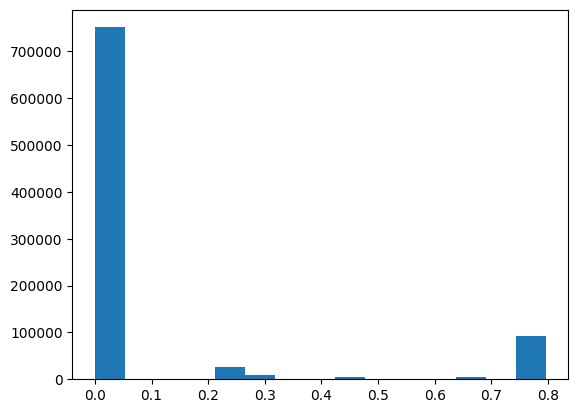

In [23]:
plt.hist(azdias_mv_r, bins=15);

In [24]:
# If we considerate a threshold of 10% of missing values
azdias_row_threshold = 0.1

azdias_RowBelow = (azdias_mv_r <= azdias_row_threshold).sum()
print(azdias_RowBelow)

azdias_RowAbove = (azdias_mv_r > azdias_row_threshold).sum()
print(azdias_RowAbove)

print('percentual of dropping rows: ', azdias_RowAbove/azdias.shape[0])

751331
139890
percentual of dropping rows:  0.1569644341863578


Considering a threshold of 0.10 we have 15% of the base being excluded, which is an acceptable value for this base treatment.

In [25]:
azdias = azdias[azdias_mv_r <= azdias_row_threshold]

### Categorical Collumns

To treat categorical features we will have 3 approaches.
1. Delete the fields for which we do not have information in the auxiliary tables.
2. Adjust fields that have small errors in the data
3. Create dummy variables

In [26]:
cate = azdias.select_dtypes(include=['object','bool','category']).columns
azdias[cate].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ
1,8A,8.0,W
2,4C,4.0,W
3,2A,2.0,W
4,6B,6.0,W
5,8C,8.0,W


1. Delete the fields for which we do not have information in the auxiliary tables.

The fields that we did not find in the axillary bases were: 'CAMEO_DEU_2015'

In [27]:
azdias = azdias.drop(columns = ['CAMEO_DEU_2015'])

1. Adjust fields that have small errors in the data

Only one field with a small error was found, namely CAMEO_DEUG_2015, in which we changed the 'X' to -1 which indicates unknow in the complementary table

In [28]:
azdias['CAMEO_DEUG_2015'].unique()

array([8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 7.0, 5.0, 3.0, nan, '3', '7', '2',
       '4', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [29]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', -1)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_DEUG_2015'].unique()

array([ 8.,  4.,  2.,  6.,  1.,  9.,  7.,  5.,  3., nan, -1.])

2. Create dummy variables

The only field we will have to create a dummy variable is 'OST_WEST_KZ'

In [30]:
#Create dummies
to_dummy = 'OST_WEST_KZ'
dummy = pd.get_dummies(azdias[to_dummy])
dummy.head()

,O,W
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1


In [31]:
# drop the original categorical variables
azdias.drop(to_dummy, axis=1, inplace=True)

# add the re-encoded one
azdias = pd.concat([azdias, dummy], axis=1)

In [32]:
cate = azdias.select_dtypes(include=['object','bool','category']).columns
cate

Index([], dtype='object')

### nan to -1

As in the support worksheet the unknown data by default is -1 we will transform everything in our bases as -1

In [33]:
azdias = azdias.fillna(value= -1)

Now that we have finished cleaning the azdias dataframe, we can create a function to be used in the other dataframes of this analysis.

In [34]:
def clean_data(df):
    '''
    This function clears the columns and rows of the dataframes of this analysis.
    input: df
    output: df_clean
    '''
    #Clean columns with no context
    drop_context = ['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
     'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 
     'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 
     'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 
     'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 
     'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 
     'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 
     'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE', 
     'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_REST', 
     'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 
     'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 
     'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_GBZ', 
     'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 
     'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 
     'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']
    df = df.drop(columns = drop_context)


    #Clean columns
    drop_columns = ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12']
    df = df.drop(columns = drop_columns)
    
    #Clean rows
    df_mv_r = df.isnull().sum(axis = 1)/df.shape[1]
    df_row_threshold = 0.1
    df = df[df_mv_r <= df_row_threshold]
    
    #Categorical collumns
    df = df.drop(columns = ['CAMEO_DEU_2015'])
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', -1)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    to_dummy = 'OST_WEST_KZ'
    dummy = pd.get_dummies(df[to_dummy])
    df.drop(to_dummy, axis=1, inplace=True)
    df = pd.concat([df, dummy], axis=1)
    
    #Nan to -1
    df = df.fillna(value= -1)
    
    #Drop KBA columns
    #kba_cols = df.columns[df.columns.str.startswith('KBA')]
    #df = df.drop(columns = kba_cols)
    
    return df

In [35]:
#Returning the dataframe to original
azdias = azdias_bkp
customers = customers_bkp

In [36]:
#Clean both dataframes with the function
azdias = clean_data(azdias)
customers = clean_data(customers)

In [37]:
#Testing if everything is ok
print('Azdias original:', azdias_bkp.shape)
print('Azdias cleaned:', azdias.shape)

print('Customers original:', customers_bkp.shape)
print('Customers cleaned:', customers.shape)

Azdias original: (891221, 366)
Azdias cleaned: (751331, 260)
Customers original: (191652, 369)
Customers cleaned: (135144, 263)


Now that we have the dataframes cleaned up we can start the customer segmentation analysis.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

We started the analysis by performing the Standardized of the data, thus ensuring that all were between 0 and 1 intervals.

In [38]:
scaler = preprocessing.StandardScaler()

azdias_scaled = scaler.fit_transform(azdias)

Then we apply the PCA method (Principal Component Analysis) in order to reduce the dimensionality of the dataset so that we can later apply a clustering algorithm.

In [39]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

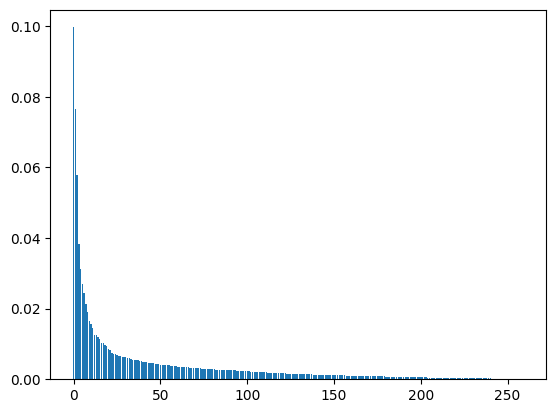

In [40]:
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.bar(ind, vals)
plt.show()

In the graph above, we can see that a component created by the PAC is responsible for explaining about 0.10 of the base and that the values of the other components decay in an exponential curve.

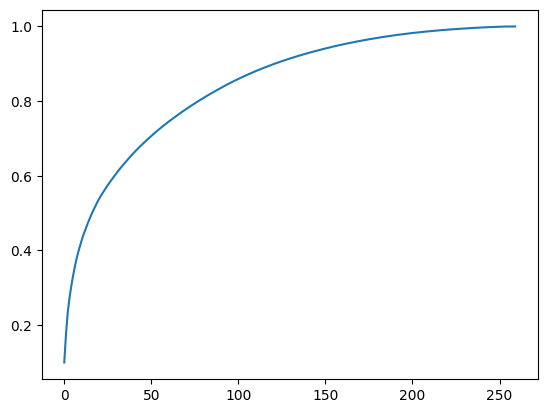

In [41]:
cumvals = np.cumsum(vals)
plt.plot(cumvals)
plt.show()

In [42]:
threshold = .90
i = np.argmax(cumvals > threshold)
print(i, cumvals[i])

121 0.9005056945986579


In this graph, in which we see the accumulated value of the understanding of the base, we observe that about 121 components explain 90% of our base. In this way, we can use the value 0.9 as threshold to create a new PCA with just these values.

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(i)
azdias_pca = pca.fit_transform(azdias_scaled)

### Interpreting PCA

As when applying the PCA we lose legibility of the base, it is necessary to analyze the main features of the components. For this, a function was used that prints the three features that most impact the component and the three that have the least impact.

In [44]:
def print_feature(features, components, i):
    
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    
    print('Highest:')
    for feature, weight in feature_weights_sorted[-3:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

    print('Lowest:')
    for feature, weight in feature_weights_sorted[:3]:
        print('\t{:20} {:.3f}'.format(feature, weight))

In [45]:
# First principal component
i = 0
print('{:5.2%}'.format(vals[i]))
print_feature(azdias.columns.values, pca.components_, i)

9.97%
Highest:
	KBA05_KRSVAN         0.169
	KBA05_KRSOBER        0.170
	KBA05_SEG6           0.189
Lowest:
	KBA05_ANTG3          -0.022
	PRAEGENDE_JUGENDJAHRE -0.021
	FINANZ_ANLEGER       -0.020


Highest:
- KBA05_KRSVAN: share of vans (referred to the county average)
- KBA05_KRSOBER: share of upper class cars (referred to the county average)
- KBA05_SEG6: share of upper class cars (BMW 7er etc.) in the microcell

Lowest:
- KBA05_ANTG3: number of 6-10 family houses in the cell
- PRAEGENDE_JUGENDJAHRE: dominating movement in the person's youth (avantgarde or mainstream)
- FINANZ_ANLEGER: financial typology: investor

PC0: is an indicator mainly linked to automobiles and inversely proportional to age.

In [46]:
# Second principal component
i = 1
print('{:5.2%}'.format(vals[i]))
print_feature(azdias.columns.values, pca.components_, i)

7.65%
Highest:
	PLZ8_BAUMAX          0.157
	PLZ8_ANTG4           0.158
	PLZ8_ANTG3           0.162
Lowest:
	MOBI_REGIO           -0.169
	PLZ8_ANTG1           -0.163
	KBA05_ANTG1          -0.160


Highest:
- PLZ8_BAUMAX : most common building-type within the PLZ8
- PLZ8_ANTG4: number of >10 family houses in the PLZ8
- PLZ8_ANTG3: number of 6-10 family houses in the PLZ8

Lowest:
- MOBI_REGIO: moving patterns
- PLZ8_ANTG1: dnumber of 1-2 family houses in the PLZ8
- KBA05_ANTG1: number of 1-2 family houses in the cell

PC1: It is mainly linked to housing.

In [47]:
# Third principal component
i = 2
print('{:5.2%}'.format(vals[i]))
print_feature(azdias.columns.values, pca.components_, i)

5.78%
Highest:
	KBA13_KMH_140_210    0.139
	KBA13_SEG_KLEINWAGEN 0.141
	KBA13_SITZE_5        0.164
Lowest:
	KBA13_HERST_BMW_BENZ -0.201
	KBA13_SEG_OBEREMITTELKLASSE -0.175
	KBA13_MERCEDES       -0.171


Highest:
- KBA13_KMH_140_210: share of cars with max speed between 140 and 210 km/h within the PLZ8
- KBA13_SEG_KLEINWAGEN: nshare of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
- KBA13_SITZE_5: number of cars with 5 seats in the PLZ8

Lowest:
- KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8
- KBA13_SEG_OBEREMITTELKLASSE: share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
- KBA13_MERCEDES: share of MERCEDES within the PLZ8

PC2: Extremely data-oriented component about cars.

### Clustering

After reducing the dimensions, we can start the grouping process by similar groups. In this work, the k-means algorithm will be used.

[208.24277951183785, 193.89364595369943, 187.0048177326198, 182.2231172495182, 179.06142455641353, 176.403971094791, 174.06448235480687, 171.86169063701698, 170.38153635363255]


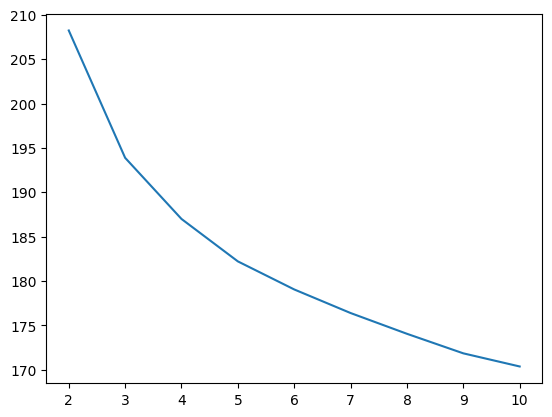

In [48]:
N = azdias_pca.shape[0]
mean_d = []
centers = range(2, 11)

for k in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    mean_d.append(abs(model.score(azdias_pca))/N)

print(mean_d)
plt.plot(range(2, len(mean_d) + 2), mean_d)

The choice of the number of clusters must be made taking into account the curve of the sum of squared error. For our project we will consider a cluster of 7, since after this value we observe a weaker decay.

In [49]:
# Train clustering model with k=8
k = 7
kmeans = KMeans(n_clusters=k)
clust_model = kmeans.fit(azdias_pca)

After creating the clusters, we need to classify both bases and understand the number of people in each of the clusters.

In [50]:
#Classifying customers
azdias_clus = kmeans.predict(azdias_pca)

#Classifying customers
customers = customers.drop(columns = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'])
customers_scaled = scaler.fit_transform(customers)
customers_pca = pca.transform(customers_scaled)
customers_clus = kmeans.predict(customers_pca)

In [51]:
#Count the numbers of population in each cluster
azdias_clus = pd.Series(azdias_clus)
customers_clus = pd.Series(customers_clus)

clus_info = pd.DataFrame([])

clus_info["Population"] = azdias_clus.value_counts().sort_index()
clus_info["Customers"] = customers_clus.value_counts().sort_index()
clus_info.reset_index(inplace=True)
clus_info.rename(columns={"index":"Cluster"}, inplace=True)

clus_info

,Cluster,Population,Customers
0,0,181921,40736
1,1,103717,8335
2,2,123463,30284
3,3,99115,25295
4,4,102695,14306
5,5,126377,15290
6,6,14043,898


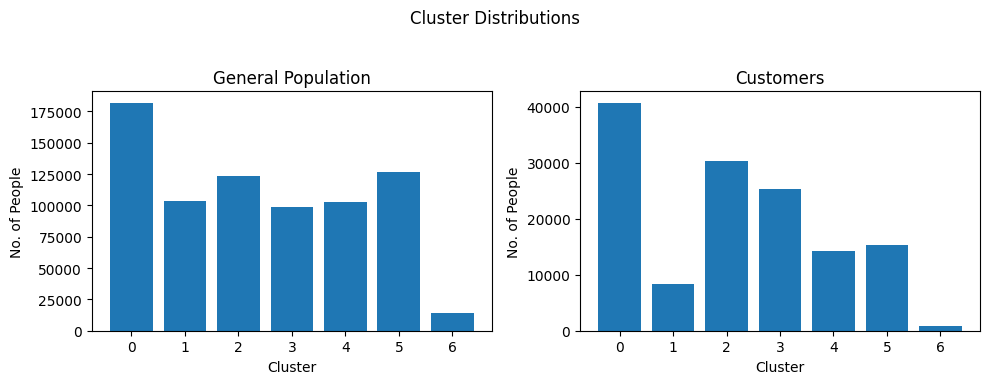

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(clus_info["Cluster"], clus_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(clus_info["Cluster"], clus_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

From the graphs, we can see that in both bases, group 4 has the highest participation. At the base of the general population, groups 0, 1, 2, 3 and 5 have a similar distribution. In the customer base, we have a greater share of groups 0 and 5.

Then we analyze the graph in percentage.

In [53]:
clus_info["Pop_proportion"] = (clus_info["Population"]/clus_info["Population"].sum()*100).round(2)
clus_info["Cust_proportion"] = (clus_info["Customers"]/clus_info["Customers"].sum()*100).round(2)

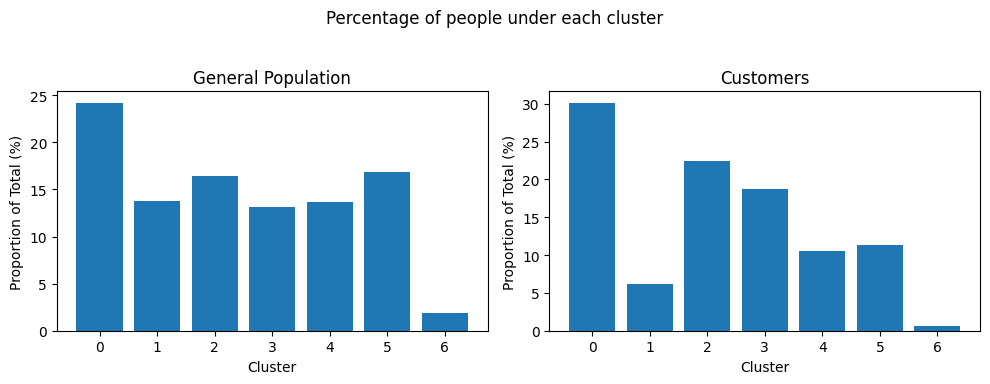

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(clus_info["Cluster"], clus_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(clus_info["Cluster"], clus_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Finally, to understand the relationship between the two graphs, we divided the percentage values of consumers by the data of the general population in order to understand in which cases we have an above-average adherence to the brand.

In [55]:
clus_info["Cust_over_Pop"] = clus_info["Cust_proportion"] / clus_info["Pop_proportion"]


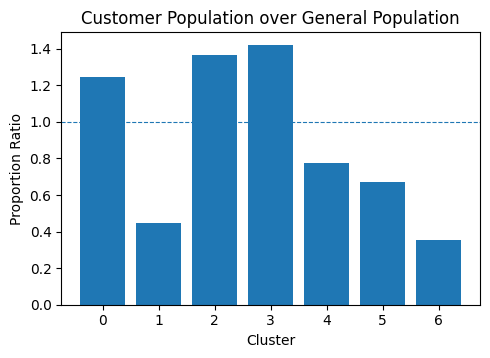

In [56]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(clus_info["Cluster"], clus_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We observe in this way that the best groups for the company are 0, 4 and 5.

If the company is planning a performance campaign it should focus on these 3 groups. Now if she wants to increase her participation in other groups she could start with an awareness campaign in the other groups.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.